In [1]:
%load_ext autoreload
%autoreload 2

# Standard libraries
import sys
import time

# Third party libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from sklearn.neighbors import KernelDensity
import SimpleITK as sitk

# Our libraries
sys.path.append('../../')
from gui.gui_shared import auto_contrast
from cell import Cell
import section
from section import Section

## Functions

In [2]:
def readTifWrapper(i, file_name):
    """
    i - index for parallel processing
    file_name - file name to open
    """
    image = readTifSection(str(file_name))
    return [i, image]


def readTifSection(file_path):
    """
    Read tif section image using SITK
    """
    image = sitk.ReadImage(str(file_path))
    image = sitk.GetArrayFromImage(image)
    image[image < 0] = 0
    image = image.T
    image = np.flip(image, axis=0)
    image = np.flip(image, axis=1)
    image  = np.squeeze(image)
    return image


def show_crop(img, points=None, x_crop=[6100, 7600], y_crop=[2450, 3300], 
              title="Image", cmap='gray', colorbar=False):
    """
    Show the crop of the image
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(img, cmap=cmap)
    if points is not None:
        for point in points:
            plt.plot(point[1], point[0], 'ro', markersize=1)
    plt.title(title)
    if x_crop is not None:
        plt.xlim(x_crop)
    if y_crop is not None:
        plt.ylim(y_crop[::-1])
    if colorbar:
        plt.colorbar()
    plt.show()
    
    
def compute_dice_coefficient(binary_image1, binary_image2):
    """
    Compute the Dice coefficient between two binary images.
    
    Parameters:
    - binary_image1: 2D numpy array representing the first binary image.
    - binary_image2: 2D numpy array representing the second binary image.
    
    Returns:
    - dice_coefficient: The Dice coefficient between the two binary images.
    """
    intersection = np.logical_and(binary_image1, binary_image2)
    return 2. * intersection.sum() / (binary_image1.sum() + binary_image2.sum())

### Load in tiff data

Brain shape: (8716, 11236)
Ground truth (section 140) shape: (66, 2)


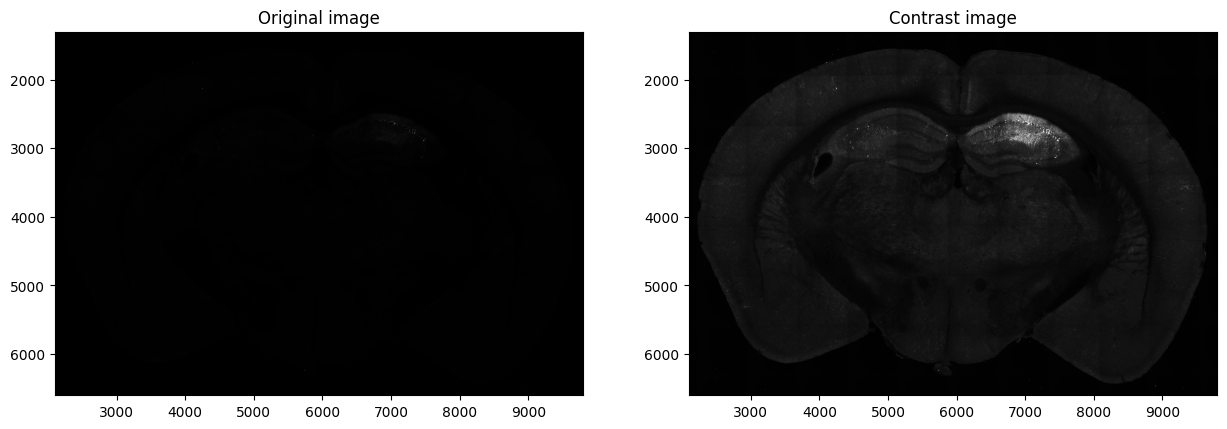

In [3]:
# Parameters for loading in the data
ch0_path = "/media/data/u01/B0039/stitched_ch0/230628_B0039_PG_U01_280-0140_1_0.tif"
ch1_path = "/media/data/u01/B0039/stitched_ch1/230628_B0039_PG_U01_280-0140_1_1.tif"
ch2_path = "/media/data/u01/B0039/stitched_ch2/230628_B0039_PG_U01_280-0140_1_2.tif"
ch3_path = "/media/data/u01/B0039/stitched_ch3/230628_B0039_PG_U01_280-0140_1_3.tif"
gt140_path = "/media/data/u01/B0039/red_section140_counts_240930_PG/red_section140_counts_240930_PG.txt"

# Load in the images
ch0 = readTifSection(ch0_path)
#ch1 = readTifSection(ch1_path)
#ch2 = readTifSection(ch2_path)
#ch3 = readTifSection(ch3_path)
img = ch0

print("Brain shape:", img.shape)

gt_points = np.loadtxt(gt140_path, skiprows=2)
gt_points = gt_points[:, 1:]  # Remove section index row
print("Ground truth (section 140) shape:", gt_points.shape)

# Contrast section
contrast_img = auto_contrast(img, alpha=0.1)

# Plot the image and contrast image
x_boundary = (2100, 9800)  # Crop out most of the background
y_boundary = (1300, 6600)
x_dca1_boundary = (6100, 7600)  # Crop the section to the region of interest
y_dca1_boundary = (2450, 3300)
x_roi_boundary = (7100, 7400)  # Crop the section to the region of interest
y_roi_boundary = (2600, 2900)

plt.figure(figsize=(15, 5))  # 20, 10
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title(f"Original image")
plt.xlim(x_boundary)
plt.ylim(y_boundary[::-1])
plt.subplot(1, 2, 2)

plt.imshow(contrast_img, cmap='gray')
plt.title(f"Contrast image")
plt.xlim(x_boundary)
plt.ylim(y_boundary[::-1])
plt.show()

Perform N4 bias correction and filtering preprocessing

https://medium.com/@alexandro.ramr777/how-to-do-bias-field-correction-with-python-156b9d51dd79

In [4]:
corrected_img = section.preprocess_image(img, alpha=1, shrink_factor=15, 
                                         median_filter_size=5, gaussian_sigma=0.2, 
                                         show=False)
contrast_corrected_img = auto_contrast(corrected_img, alpha=0.25)  # Just for visualization

Corrected image stats:
	Shape: (8716, 11236)
	Min: 0.0
	Max: 25210.8440939318
	Median: 17.818282875511834
	Mean: 64.2367677816755
	Std: 105.76834962780245

Threshold value: 2179.6037603377245


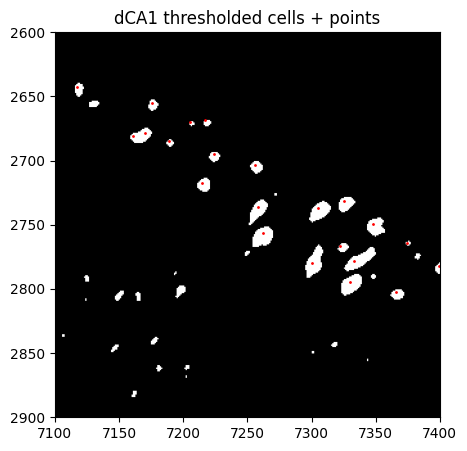

In [5]:
gaussian_img_min, gaussian_img_max, gaussian_img_median, gaussian_img_mean, gaussian_img_std = section.get_stats(corrected_img, title="Corrected image stats:")
threshold_value = gaussian_img_mean + 20 * gaussian_img_std
print("Threshold value:", threshold_value)

thresholded_img = np.where(corrected_img > threshold_value, 1, 0).astype(bool)  # Binarize
show_crop(thresholded_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, title=f"dCA1 thresholded cells + points", cmap='gray')

## Section class

https://pythonspeed.com/articles/numpy-memory-footprint/

In [6]:
section139 = np.load("section139_coo.pkl", allow_pickle=True)

#section = Section(img, 139)
#section.process()
#print("Done processing section")
#section.save("section139_coo.pkl")

In [7]:
sample_df = section139.sort(key='area')

area_threshold = 20
labels_with_small_area = sample_df[sample_df['area'] < area_threshold]['label'].tolist()
print("Number of labels with small area:", len(labels_with_small_area))
print(labels_with_small_area)

for l in labels_with_small_area:
    print("Removing label", l)
    section139.remove(l)

sample_df

Number of labels with small area: 80
[9, 131, 63, 110, 52, 68, 86, 124, 77, 114, 157, 103, 72, 135, 69, 65, 54, 4, 123, 133, 163, 5, 37, 67, 98, 76, 115, 91, 59, 33, 49, 132, 25, 148, 130, 125, 139, 134, 50, 162, 156, 108, 161, 160, 116, 73, 147, 58, 83, 129, 128, 149, 95, 117, 138, 57, 150, 153, 12, 45, 1, 106, 74, 100, 99, 118, 93, 105, 113, 121, 140, 6, 109, 159, 120, 90, 151, 88, 126, 55]
Removing label 9
Removing label 131
Removing label 63
Removing label 110
Removing label 52
Removing label 68
Removing label 86
Removing label 124
Removing label 77
Removing label 114
Removing label 157
Removing label 103
Removing label 72
Removing label 135
Removing label 69
Removing label 65
Removing label 54
Removing label 4
Removing label 123
Removing label 133
Removing label 163
Removing label 5
Removing label 37
Removing label 67
Removing label 98
Removing label 76
Removing label 115
Removing label 91
Removing label 59
Removing label 33
Removing label 49
Removing label 132
Removing label 25
R

,label,area,convexity,eccentricity,ellipse dice
15,16,849,0.438307,0.837417,0.477987
63,64,211,0.959091,0.895812,0.868735
65,66,209,0.958716,0.946358,0.898551
126,127,198,0.994975,0.849247,0.900256
52,53,196,0.994924,0.705928,0.906250
...,...,...,...,...,...
89,90,2,0.000000,0.816497,0.800000
150,151,2,0.000000,0.816497,0.800000
87,88,2,0.000000,0.816497,0.800000
125,126,1,0.000000,0.122682,1.000000


## Run sample tests with the Cell class

In [8]:
from cell import Cell

def show_cell(section_obj, label: int, contrast_img: np.ndarray=None, spacing=12):
    """
    Show the labeled cell with the specified label.
    
    Parameters:
    - label: The label of the cell to show.
    - contrast_img: The contrast image to overlay the cell on.
    """

    # Create a Cell object
    cell = section_obj[label]
    
    # Show the cell
    cell.show(contrast_img)
    cell.locate(contrast_img, spacing=spacing)
    _ = cell.get_stats(corrected_img)
    print()
    
branching_cell = np.load("data/branching_component.npy")
contrast_img = auto_contrast(img, alpha=0.025)

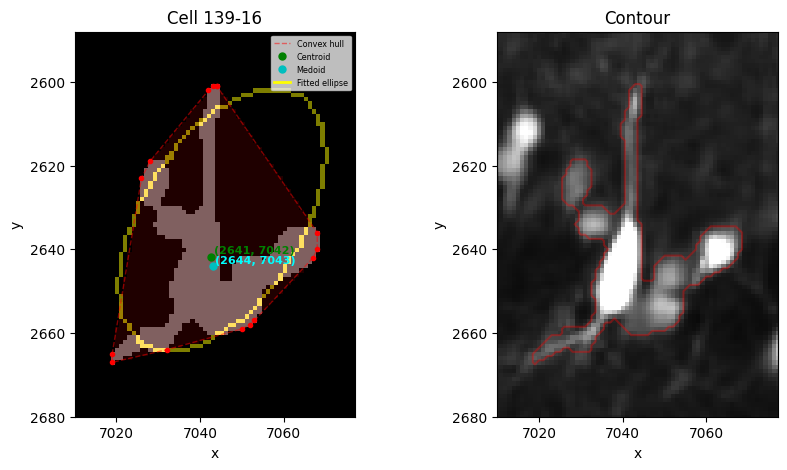

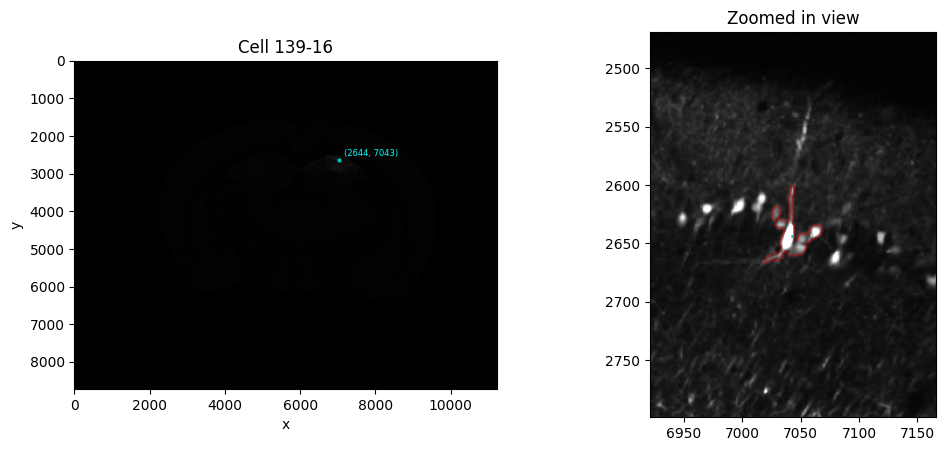

Cell 139-16
  Geometric stats
      Cell area: 849 pixels
      Convexity: 0.43830665978316985
      Eccentricity: 0.8374173092019966
      Ellipse Dice coefficient: 0.4779874213836478
  Image stats
      Image shape: (8716, 11236)
      Centroid: (2641.733804475854, 7042.679623085984)
      Medoid: (2644, 7043)
  Intensity stats
      Min: 2184.0682157354536
      Max: 23910.078407610246
      Median: 3506.830579304873
      Mean: 5497.640987875636
      Std: 4865.312714262219




In [9]:
show_cell(section139, 16, contrast_img, spacing=2)
#cell = Cell(branching_cell, 140, 16)
#cell.show(contrast_img)
#cell.locate(contrast_img)
#_ = cell.get_stats(corrected_img)

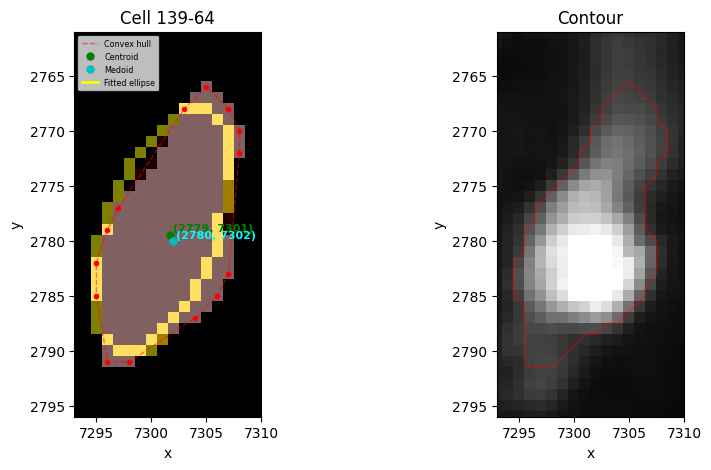

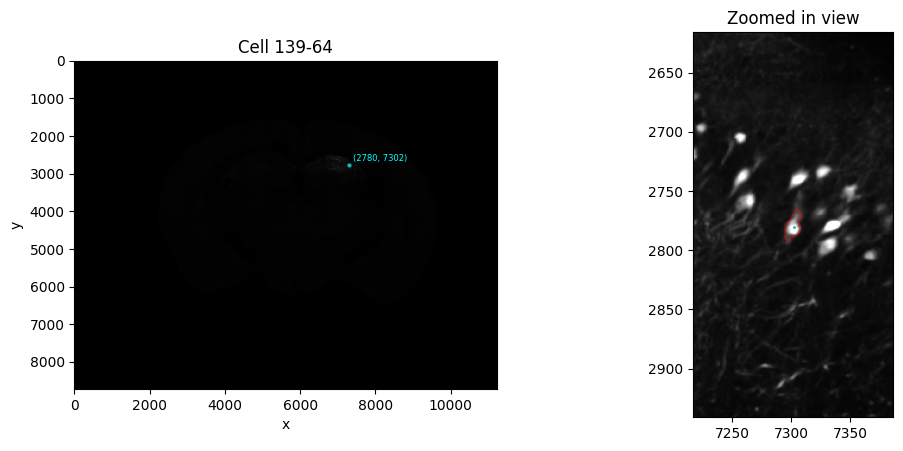

Cell 139-64
  Geometric stats
      Cell area: 211 pixels
      Convexity: 0.9590909090909091
      Eccentricity: 0.895811940533499
      Ellipse Dice coefficient: 0.8687350835322196
  Image stats
      Image shape: (8716, 11236)
      Centroid: (2779.445497630332, 7301.677725118483)
      Medoid: (2780, 7302)
  Intensity stats
      Min: 2186.6518190196607
      Max: 10197.684328346579
      Median: 4196.536452835768
      Mean: 4867.374314211183
      Std: 2367.8783891331086




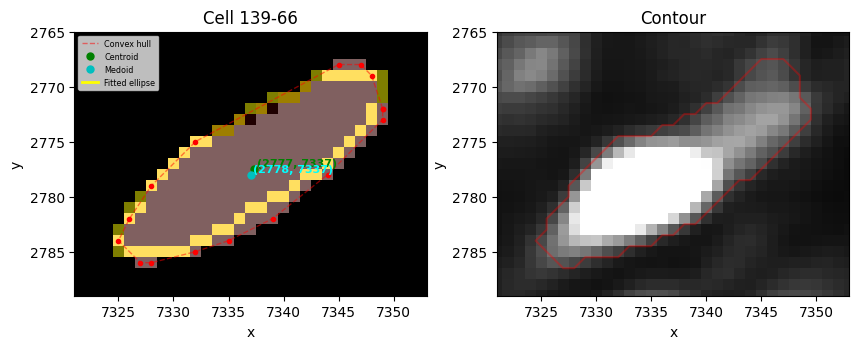

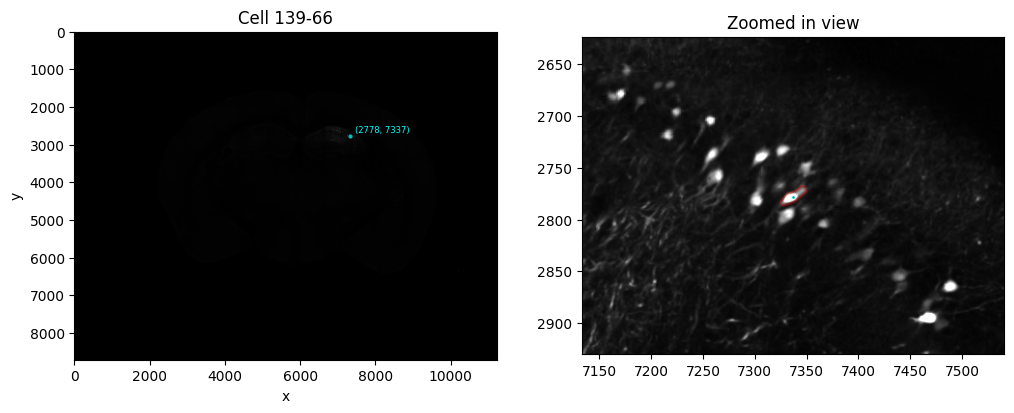

Cell 139-66
  Geometric stats
      Cell area: 209 pixels
      Convexity: 0.9587155963302753
      Eccentricity: 0.9463581987338892
      Ellipse Dice coefficient: 0.8985507246376812
  Image stats
      Image shape: (8716, 11236)
      Centroid: (2777.4832535885166, 7337.315789473684)
      Medoid: (2778, 7337)
  Intensity stats
      Min: 2188.4161899827373
      Max: 17058.96818113412
      Median: 5076.108555230147
      Mean: 6959.044502557572
      Std: 4535.023549297472




KeyError: 153

In [10]:
show_cell(section139, 64, contrast_img, spacing=6)
show_cell(section139, 66, contrast_img, spacing=8)
#show_cell(section139, 128, contrast_img, spacing=8)
#show_cell(section139, 153, contrast_img, spacing=8)

In [11]:
def compute_weighted_centroid(image):
    # Ensure the image is a numpy array
    image = np.array(image)
    
    # Get the coordinates of all pixels
    y_indices, x_indices = np.indices(image.shape)
    
    # Compute the weighted sum of the coordinates
    total_weight = np.sum(image)
    x_weighted_sum = np.sum(x_indices * image)
    y_weighted_sum = np.sum(y_indices * image)
    
    # Compute the centroid
    x_centroid = x_weighted_sum / total_weight
    y_centroid = y_weighted_sum / total_weight
    
    return (x_centroid, y_centroid)


def compute_weighted_medoid(image):
    # Ensure the image is a numpy array
    image = np.array(image)
    
    # Get the coordinates of all pixels
    y_indices, x_indices = np.indices(image.shape)
    coordinates = np.stack((y_indices, x_indices), axis=-1).reshape(-1, 2)
    
    # Flatten the image to get the weights
    weights = image.flatten()
    
    # Compute the weighted distance for each pixel to all other pixels
    min_distance = float('inf')
    medoid = None
    
    for coord in coordinates:
        distances = np.sqrt((coordinates[:, 0] - coord[0])**2 + (coordinates[:, 1] - coord[1])**2)
        weighted_distance = np.sum(distances * weights)
        
        if weighted_distance < min_distance:
            min_distance = weighted_distance
            medoid = coord
    
    return tuple(medoid)

# Example usage
image = np.array([[0, 0, 0, 0],
                  [0, 1, 2, 0],
                  [0, 3, 4, 0],
                  [0, 0, 0, 0]])

medoid = compute_weighted_medoid(image)
print("Weighted medoid:", medoid)

Weighted medoid: (2, 2)
